# MintPy Processing

## Setup

In [1]:
# %matplotlib widget
%matplotlib inline
import glob
import sys
import shutil
import os
import matplotlib.pyplot as plt
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix
from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity

In [2]:
cd /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy

/u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy


In [3]:
!smallbaselineApp.py -g ../JPL_internship/Haywrd_05502_01-S1.cfg

--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
    mintpy.load.updateMode: no --> auto
    mintpy.load.metaFile: ../Igrams/\*/referenceShelve/data.dat --> ../Igrams/*/referenceShelve/data.dat
    mintpy.load.unwFile: ../Igrams/\*/filt_\*.unw --> ../Igrams/*/filt_*.unw
    mintpy.load.corFile: ../Igrams/\*/filt_\*.cor --> ../Igrams/*/filt_*.cor
    mintpy.load.connCompFile: ../Igrams/\*/filt_\*.unw.conncomp --> ../Igrams/*/filt_*.unw.conncomp
copy Haywrd_05502_01-S1.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy Haywrd_05502_01-S1.cfg to pic      directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read def

In [2]:
!pwd

/u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy


In [3]:
!nproc

32


In [5]:
# ~30 GB of ram
!cat /proc/meminfo

MemTotal:       131447096 kB
MemFree:        27293156 kB
MemAvailable:   44729476 kB
Buffers:           13920 kB
Cached:         14223400 kB
SwapCached:          112 kB
Active:          8565776 kB
Inactive:        8812456 kB
Active(anon):    3078256 kB
Inactive(anon):   187888 kB
Active(file):    5487520 kB
Inactive(file):  8624568 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:       4194296 kB
SwapFree:        4189424 kB
Dirty:                 0 kB
Writeback:             0 kB
AnonPages:       3109600 kB
Mapped:           214720 kB
Shmem:            125232 kB
Slab:           28174844 kB
SReclaimable:    3950240 kB
SUnreclaim:     24224604 kB
KernelStack:       19872 kB
PageTables:        23836 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    69917844 kB
Committed_AS:   21244252 kB
VmallocTotal:   34359738367 kB
VmallocUsed:     4136692 kB
VmallocChunk:   34286476152 kB
Percpu:            81920 kB
HardwareCorru

## A note on the los files:

**From Eric:** Checked the geom_reference/los.rdr file and it is actually BSQ, but the los.rdr.xml file has the scheme as BIP. This explains why MintPy is reading it wrong. Hand-edited the xml file and ran fixImageXml.py to generate the corrected los.rdr.vrt file. Also edited the los.rdr.rsc file to correct the scheme there.

## load_data

In [77]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep load_data

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-04 14:51:52.924155--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
    mintpy.load.updateMode: yes --> no
    mintpy.load.metaFile: ../Igrams/\*/referenceShelve/data.dat --> ../Igram

## Check for correct loading of incidence angle

view.py inputs/geometryRadar.h5 azimuthAngle incidenceAngle --noverbose


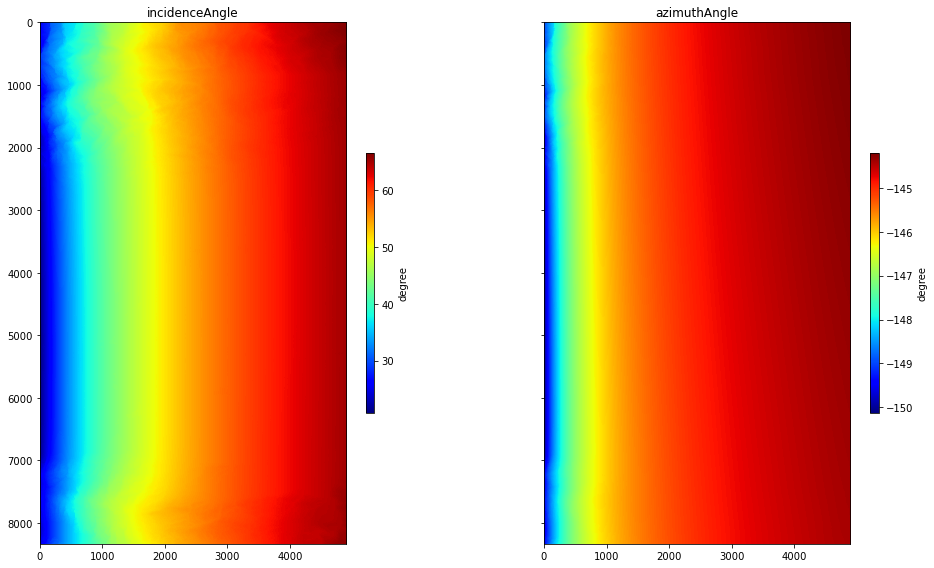

In [78]:
fig = view.main('inputs/geometryRadar.h5 azimuthAngle incidenceAngle --noverbose'.split())

Outputs look good, don't need to edit the xml files!

## Generate Water Mask

input geometry file: ./inputs/geometryRadar.h5
read ./inputs/geometryRadar.h5 waterMask
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.5
delete exsited file: waterMask.h5
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (8333, 4892)         with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.4 secs.
view.py waterMask.h5 --noverbose


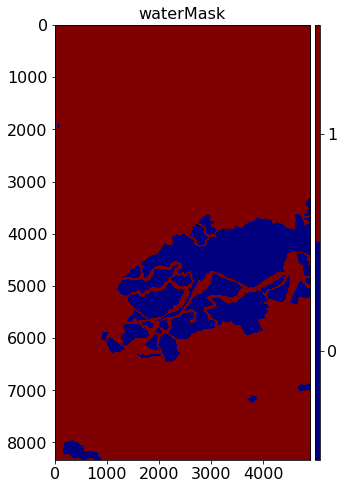

In [79]:
!generate_mask.py ./inputs/geometryRadar.h5 waterMask -m 0.5 -o waterMask.h5
view.main('waterMask.h5 --noverbose'.split())

## modify_network

Looks like we also need to remove interferograms `20090220_20091119`, `20090220_20100301`, and `20151008_20171020`.

In [76]:
# !modify_network.py -h
# !modify_network.py ./inputs/ifgramStack.h5 --exclude-ifg-index 1 3 35


open ifgramStack file: ifgramStack.h5
number of interferograms: 54
--------------------------------------------------
Drop ifgrams with the following index number: 3
0 : 20090220_20100115
1 : 20090220_20100423
2 : 20120413_20140528
--------------------------------------------------
number of interferograms to remove: 3
number of interferograms to keep  : 51
open file ./inputs/ifgramStack.h5 with r+ mode
update HDF5 dataset "/dropIfgram".
update MODIFICATION_TIME in HDF5 dataset "/unwrapPhase"
update MODIFICATION_TIME in HDF5 dataset "/coherence"
update MODIFICATION_TIME in HDF5 dataset "/connectComponent"
touch coherenceSpatialAvg.txt
Done.


MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-04 15:13:38.510258--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
    mintpy.load.metaFile: ../Igrams/\*/referenceShelve/data.dat --> ../Igrams/*/referenceShelve/data.dat
    mintpy.load.unwFile

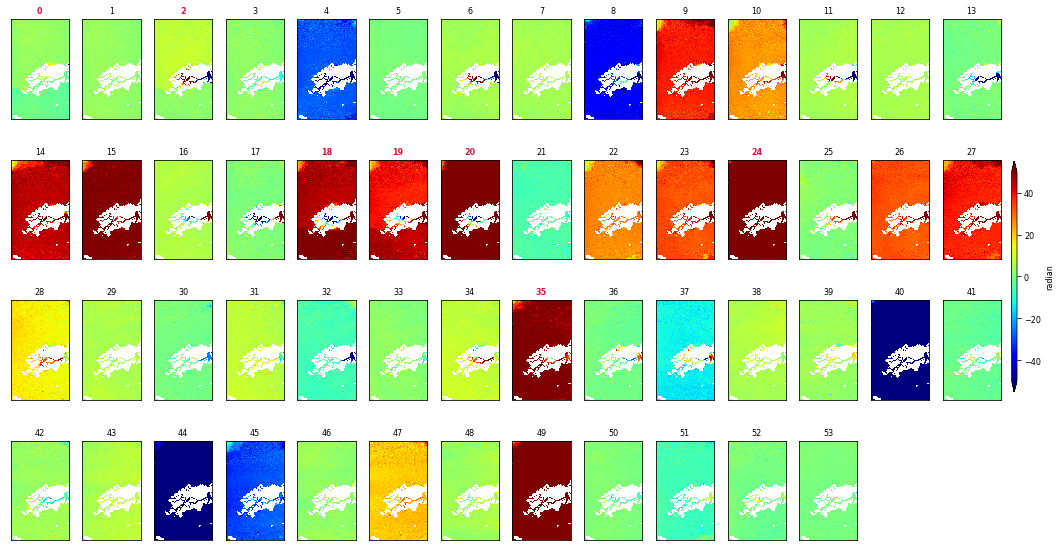

In [98]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep modify_network
view.main('./inputs/ifgramStack.h5 unwrapPhase --noverbose -m waterMask.h5 --vlim -50 50'.split())

There are quite a few interferograms with large phase differences, but for now let's just remove interferograms with phase discontinuities [0,2,18]

read options from template file: Haywrd_05502_01-S1.cfg
read temporal/spatial baseline info from file: ./inputs/ifgramStack.h5
['coherenceSpatialAvg.txt'] exists and is newer than ['./inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
coherenceSpatialAvg.txt already exists, read it directly
number of acquisitions: 19
number of interferograms: 54
shift all perp baseline by 0.0 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 7
number of interferograms marked as keep: 47
number of acquisitions marked as drop: 0
max perpendicular baseline: 0.00 m
max temporal      baseline: 798.0 days
showing coherence
data range: [0.379, 0.8223]
display range: (0.2, 1.0)


/home/fwilliam/tools/MintPy/mintpy/utils/plot.py:464: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([ymin, ymax])


showing ...


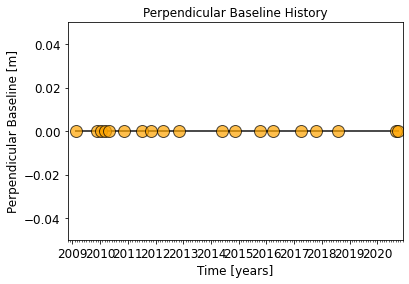

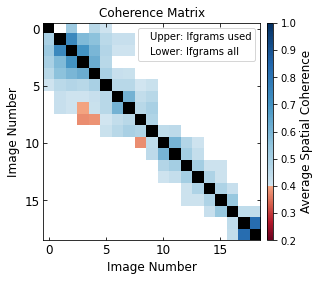

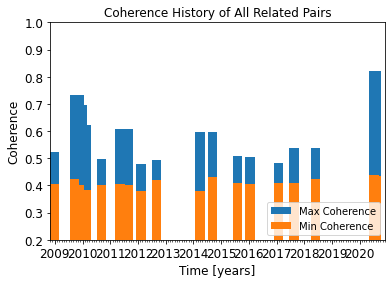

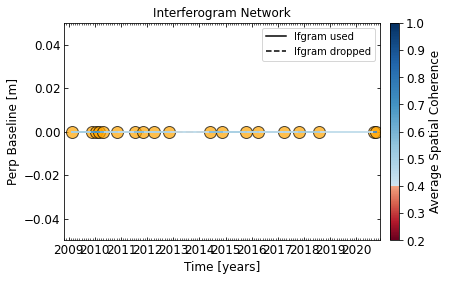

In [103]:
plot_network.main('./inputs/ifgramStack.h5 -t ../JPL_internship/Haywrd_05502_01-S1.cfg'.split())

Dropped 7 of 54 interferograms, but still have fully connected network with avgSpatialCoh > 0.4 threshold

## reference_point

In [104]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep reference_point

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-04 15:17:22.104530--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
copy Haywrd_05502_0

## quick_overview

In [108]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep quick_overview

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-04 15:25:46.540655--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['quick_overview']
Remaining steps: ['correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/

view.py avgPhaseVelocity.h5 --noverbose -m waterMask.h5 --vlim -3 3


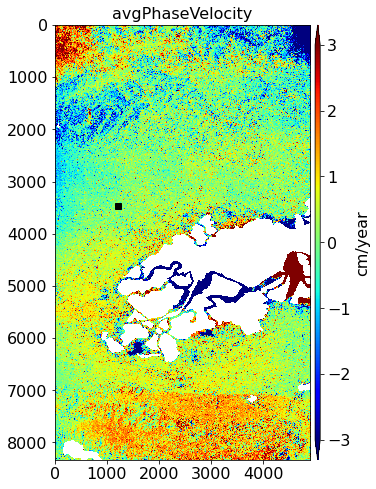

plot and save figure to file numTriNonzeroIntAmbiguity.png


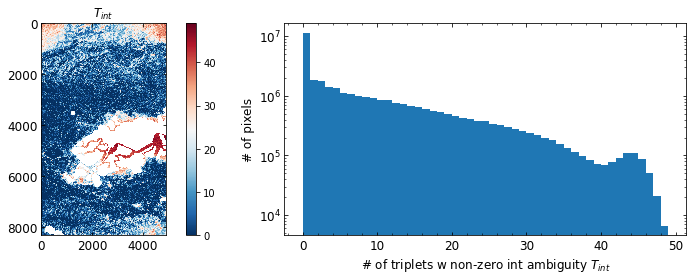

In [111]:
view.main('avgPhaseVelocity.h5 --noverbose -m waterMask.h5 --vlim -3 3'.split())
plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True, fig_size=[12, 4])

## correct_unwrap_error

In [112]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep correct_unwrap_error

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-04 15:27:38.463397--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_unwrap_error']
Remaining steps: ['invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAV

## invert_network
This takes a while so we write it to a log

In [ ]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep invert_network |& tee -i invert.log ; python ../JPL_internship/emailme.py

In [3]:
!cat invert.log

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-04 15:28:38.753650--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_

## correct_LOD

In [4]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep correct_LOD

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:34:23.711514--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_LOD']
Remaining steps: ['correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/small

## correct_SET

In [5]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep correct_SET

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:34:43.123332--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_SET']
Remaining steps: ['correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg

## correct_troposphere

In [6]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep correct_troposphere

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:34:55.511547--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_troposphere']
Remaining steps: ['deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


************

## deramp

In [7]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep deramp

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:35:05.741736--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - deramp 

## correct_topography

In [8]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep correct_topography

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:36:26.263882--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - correct_topograph

## residual_RMS

In [9]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep residual_RMS

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:36:34.442899--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - residual_RMS ********************
No re

## reference_date

In [10]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep reference_date

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:36:44.766654--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - reference_date ********************

reference_date.py 

## velocity

In [11]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep velocity

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:36:57.065048--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseries2velocity.py /u/sar-r2/fwilliam/

## geocode

In [12]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep geocode

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:37:23.927209--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['geocode']
Remaining steps: ['google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - geocode ********************

geocode.py /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywr

## google_earth

In [13]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep google_earth

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-05 12:41:42.712127--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['google_earth']
Remaining steps: ['hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg


******************** step - google_earth ********************
creating Google Earth KMZ file for geocoded velocity file: ...

## Export to GDAL

In [14]:
!save_gdal.py ./geo/geo_velocity.h5 -o ./geo/velocity.tif

read metadata from file: ./geo/geo_velocity.h5
read data     from file: ./geo/geo_velocity.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 8333, 4892
raster transform info: (-122.30984445672122, 0.00010578355962721709, 0, 37.60865271806831, 0, -4.3168070221313536e-05)
write data to raster band
set projectection as: EPSG 4326
finished writing to /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/geo/velocity.tif


## View Results

### Dem with velocity overlay

view.py ./geo/geo_velocity.h5 velocity --dem ./geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose --vlim -2 2


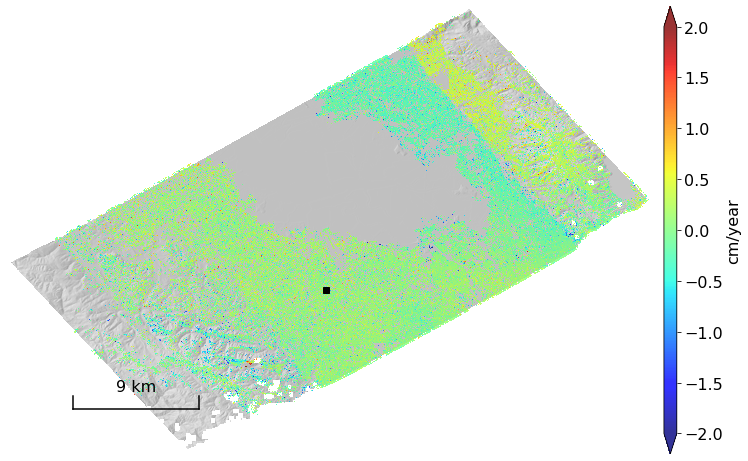

In [22]:
view.main('./geo/geo_velocity.h5 velocity --dem ./geo/geo_geometryRadar.h5 --shade-exag 0.05 --figsize 12 12 --notitle --notick --noaxis --noverbose --vlim -2 2'.split())

### Temporal Coherence

view.py temporalCoherence.h5 --noverbose


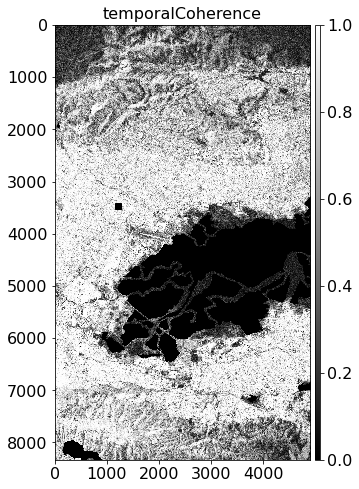

In [16]:
view.main('temporalCoherence.h5 --noverbose'.split())

### Phase Ambiguity

plot and save figure to file numTriNonzeroIntAmbiguity.png


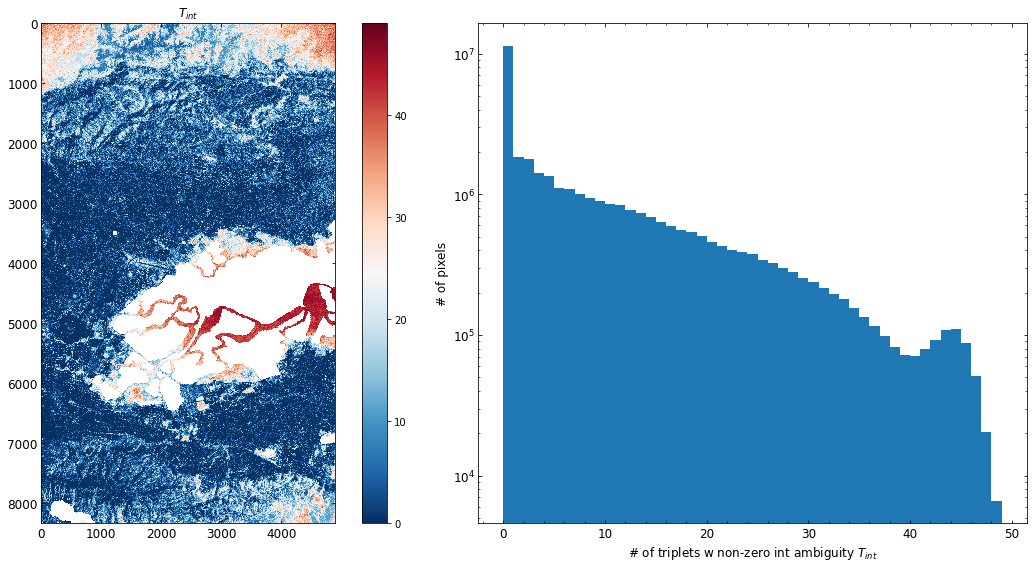

In [17]:
from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity
plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True, fig_size=[16, 8])

### Velocity with VelocityStd

view.py velocity.h5 --noverbose


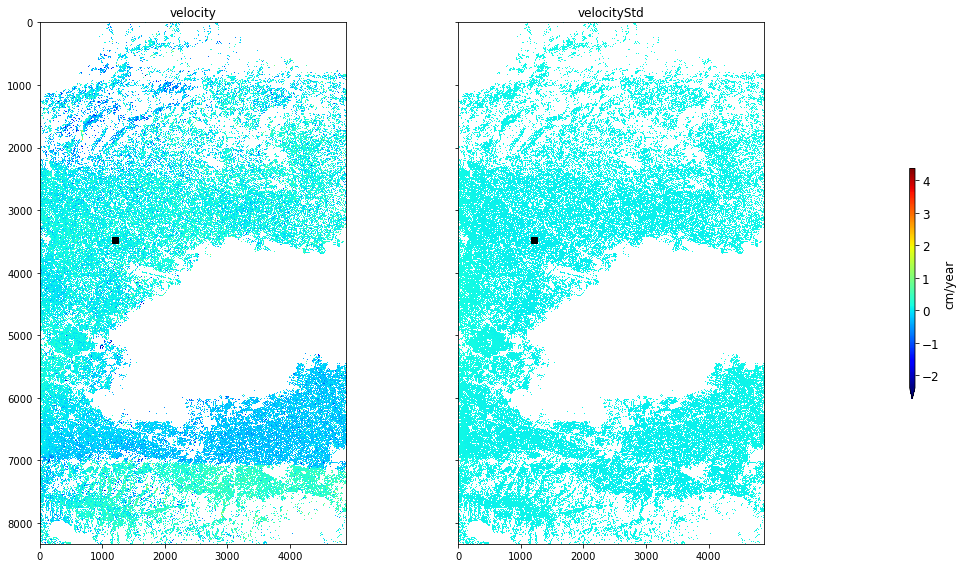

In [18]:
view.main('velocity.h5 --noverbose'.split())

view.py velocity.h5 --noverbose --vlim -2 2


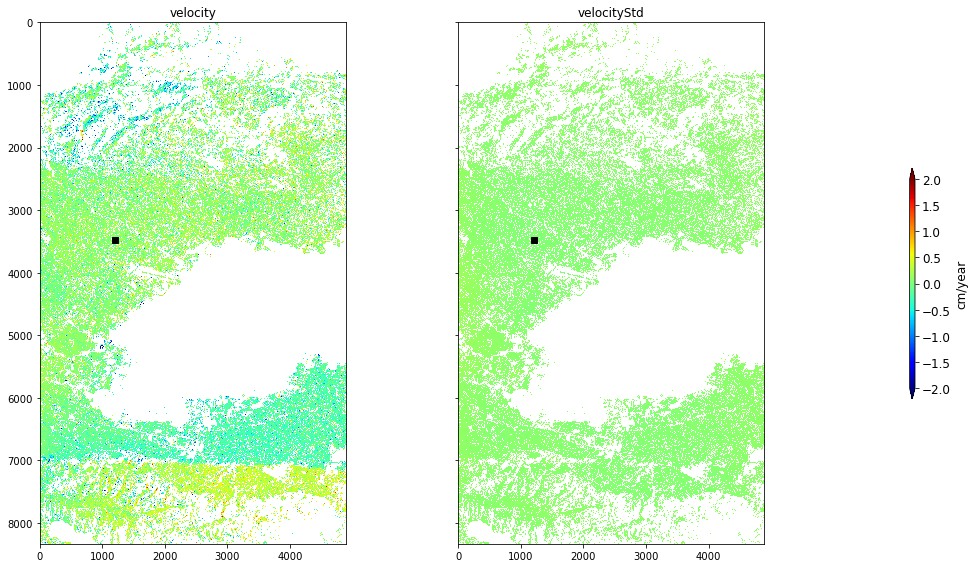

In [21]:
view.main('velocity.h5 --noverbose --vlim -2 2'.split())